In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190606

In [2]:
import os
import pytz
import datetime as dt
import numpy as np
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190606 (07 broken!)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190608


In [5]:
import cs230_project_utilities as utils

In [6]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

In [7]:
def localized_timestamp():
    return dt.datetime.now(tz=pytz.timezone('America/Los_Angeles')).strftime("%Y-%m-%d_%H:%M:%S")

In [8]:
# Predict on a test batch

def predict_and_visualize(model, x, y):

    # Run model
    y_pred = model.predict(x)

    # Inspect output
    for i in range(len(x)):

        fft = utils.fastmri._combine_two_channels_of_complex_tensor(x[i]).numpy()
        fft_mag = np.abs(fft)
        fft_ang = np.angle(fft)
        reconstruction = y_pred[i, ..., 0]
        image = y[i, ..., 0]

        MSE = utils.signal_processing.mean_square_error(reconstruction, image)
        PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

        plt.subplot(2, 2, 1)
        plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
        utils.plot.imshowgray(reconstruction)

        plt.subplot(2, 2, 2)
        plt.title('FFT (Magnitude)')
        utils.plot.imshowfft(fft_mag)

        plt.subplot(2, 2, 3)
        plt.title('Expected reconstruction')
        utils.plot.imshowgray(image)

        plt.subplot(2, 2, 4)
        plt.title('FFT (Phase)')
        utils.plot.imshowgray(fft_ang)

        plt.show()
        break
        
    print('For validation: x.sum()={}, y.sum()={}, y_pred.sum()={}'.format(x.sum(), y.sum(), y_pred.sum()))
    print('Model iterations: {}'.format(model.optimizer.iterations.numpy()))
        
    # Return model output
    return y_pred

# Load a saved model

def restore_model(restore_path, weights_only, model=None, custom_objects=None):
    '''
    Restoring saved models
    
    - To restore a `tf.keras.Model` saved with `model.save_weights(...)`:
        Set `weights_only` to `True`. Restore weights at `restore_path` into `model`.
    - To restore a `tf.keras.Model` saved with `model.save(...)`:
        Set `weights_only` to `False`. Load and return and entire model at `restore_path`,
        optionally passing in the dictionary `custom_objects`.
    '''
    if weights_only:
        assert model is not None, 'Must pass a model if only restoring weights.'
        model.load_weights(restore_path)
    else:
        assert model is None, 'Do not pass a model if only restoring weights. A model will be returned.'
        model = tf.keras.models.load_model(restore_path, custom_objects=custom_objects)

    return model



# Load dataset as TFRecords 

In [9]:
# Sync from remote storage in s3
# aws s3 sync s3://cs230-automap/data/fastmri/tfrecords cs230/data/fastmri/tfrecords

In [10]:
dev_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_dev/*.tfrecord'
test_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'
train_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_train/*.tfrecord'

In [11]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

batch_size = 32

dev_dataset = utils.fastmri.load_dataset(dev_locations,
                                         batch_size=8,
                                         shuffle_buffer_size=384,
                                         load_original_reconstruction=False,
                                         include_all_parsed_features=False,
                                         ignore_errors=True,
                                         data_augmentation='symmetric')

test_dataset = utils.fastmri.load_dataset(test_locations,
                                          batch_size=8,
                                          shuffle_buffer_size=384,
                                          load_original_reconstruction=False,
                                          include_all_parsed_features=False,
                                          ignore_errors=True,
                                          data_augmentation=None)

train_dataset = utils.fastmri.load_dataset(train_locations,
                                           batch_size=batch_size,
                                           shuffle_buffer_size=1024,
                                           load_original_reconstruction=False,
                                           include_all_parsed_features=False,
                                           ignore_errors=True,
                                           data_augmentation='symmetric')

Loading dataset... Shuffle items? True. Shuffle buffer: 384
Loading dataset... Shuffle items? True. Shuffle buffer: 384
Loading dataset... Shuffle items? True. Shuffle buffer: 1024


# Validate dataset
Make sure target reconstruction is the same as reconstruction computed from input.

In [12]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

In [13]:
def first_batches():
    batches = [(first_test_batch, 'Test'), (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    return batches

In [14]:
first_test_batch[0].shape

TensorShape([8, 128, 128, 2])

In [15]:
fft, target_image = first_test_batch[0][-1].numpy().squeeze(), first_test_batch[1][-1].numpy().squeeze()
fft = utils.fastmri._combine_two_channels_of_complex_tensor(fft).numpy()

# Compute image from input `fft`
image_from_fft = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

# Compare target image to reconstruction from input `fft`
np.allclose(image_from_fft, target_image, atol=1e-6), utils.signal_processing.mean_square_error(image_from_fft, target_image)

(True, 3.5894156e-15)

In [16]:
# Should be in [0, 1]
image_from_fft.min(), image_from_fft.max(), target_image.min(), target_image.max()

(0.00032979753, 0.99999976, 0.00032988636, 1.0)

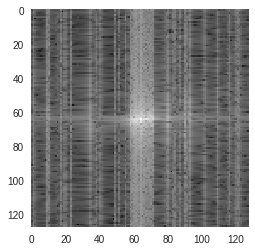

In [17]:
utils.plot.imshowfft(fft)

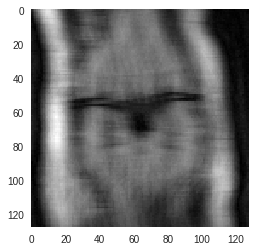

In [18]:
utils.plot.imshowgray(target_image)

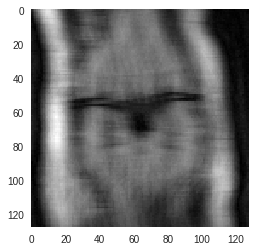

In [19]:
utils.plot.imshowgray(image_from_fft)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


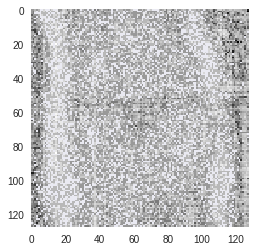

In [20]:
utils.plot.imshowfft(np.square(target_image - image_from_fft))

# Model

In [21]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [22]:
# Model most similar to OG AUTOMAP
# def load_uncompiled_automap_model():

#     N = 128
#     X = tf.keras.layers.Input(shape=(N, N, 2))

#     # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
#     # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
#     # noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
#     # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

#     ds_flat = tf.keras.layers.Flatten()(X)

# #     fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
# #     fc1 = tf.keras.layers.Dropout(0.05)(fc1)
#     fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(ds_flat)

#     fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

#     conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
#     # L1 regularization to encourage sparsity
#     conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
#                                    activity_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [23]:
# def load_uncompiled_automap_model():
    
#     # this one's solid, but I believe we'll need a few hours to train it.
    
#     N = 128
#     F = 32
#     X = tf.keras.layers.Input(shape=(N, N, 2))

# #     Half-assed data augmentation
# #     noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (N, N, 2)

#     # These layers all halve the spatial dimension (but also each output F channels)
#     conv1 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(X),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(X)])
#     pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # spatial dim: N / 2
    
#     conv2 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool1),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool1)])
#     pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # spatial dim: N / 4
    
#     conv3 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(pool2),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(pool2)])
#     pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # spatial dim: N / 8
    
#     conv4 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(pool3),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(pool3)])
#     # spatial dim: N / 4
    
#     conv5 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv4),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv4)])
#     # spatial dim: N / 2
    
#     conv6 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=2, activation='relu', padding='same')(conv5),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=2, activation='relu', padding='same')(conv5)])
#     # spatial dim: N
    
#     conv7 = tf.keras.layers.Concatenate(axis=-1)([
#         tf.keras.layers.Conv2D(F, (3, 3), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (5, 5), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2D(F, (7, 7), strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 3, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same')(conv6),
#         tf.keras.layers.Conv2DTranspose(F, 7, strides=1, activation='relu', padding='same')(conv6)])
    
#     t_conv8 = tf.keras.layers.Conv2DTranspose(6 * F, 5, strides=1, activation='relu', padding='same',
#                                               # Encourage sparsity in output (MRI images are mostly zeros)
#                                               activity_regularizer=tf.keras.regularizers.l1(1e-6))(conv7)

#     Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv8) # spatial dim: 128

#     model = tf.keras.Model(inputs=X, outputs=Y_pred)

#     return model

In [24]:
def load_uncompiled_automap_model():
    
    # this one's solid, but I believe we'll need a few hours to train it.
    
    N = 128
    F = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Half-assed data augmentation
    noisy_X = tf.keras.layers.GaussianNoise(stddev=1e-7)(X) # shape: (256, 256, 256)

    # These layers all halve the spatial dimension (but also each output 256 channels)
    conv1 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(X)
    pool1 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv1) # shape: (128, 128, F)

    conv2 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv2) # shape: (64, 64, F)

    conv3 = tf.keras.layers.Conv2D(F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool2)
    pool3 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv3) # shape: (32, 32, F)

    conv4 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool3)
    pool4 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv4) # shape: (16, 16, F)

    conv5 = tf.keras.layers.Conv2D(2 * F, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool4)
    pool5 = tf.keras.layers.AveragePooling2D(pool_size=2)(conv5) # shape: (8, 8, F)

    # A "FC-like" layer for fun before we do upsampling
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(pool5) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(4 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4
    conv7 = tf.keras.layers.Conv2D(2 * F, (2, 2), strides=(1, 1), activation='relu', padding='same')(conv7) # spatial dim: 4

    # These transposed convolutions upsample spatial dimension by 2
    t_conv1 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(conv7) # spatial dim: 8
    t_conv2 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv1) # spatial dim: 16
    t_conv3 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv2) # spatial dim: 32
    t_conv4 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv3) # spatial dim: 64
    t_conv5 = tf.keras.layers.Conv2DTranspose(F, 3, strides=2, activation='relu', padding='same')(t_conv4) # spatial dim: 128
    
    t_conv6 = tf.keras.layers.Conv2DTranspose(F, 5, strides=1, activation='relu', padding='same',
                                              # Encourage sparsity in output (MRI images are mostly zeros)
                                              activity_regularizer=tf.keras.regularizers.l1(1e-6))(t_conv5)
    
    Y_pred = tf.keras.layers.Conv2DTranspose(1, 7, strides=1, activation='relu', padding='same')(t_conv6) # spatial dim: 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [25]:
def lr_schedule(epoch):
    initial_lr = 2e-4
    if epoch < 20:
        return 2e-4
    elif epoch >= 20 and epoch < 120:
        return 1e-4
    elif epoch >= 120 and epoch < 150:
        return 1e-5
    elif epoch >= 150 and epoch < 170:
        return 5e-5
    elif epoch >= 170 and epoch < 200:
        return 1e-5
    elif epoch >= 200 and epoch < 220:
        return 1e-6
    elif epoch >= 220 and epoch < 250:
        return 5e-6
    elif epoch >= 250 and epoch < 270:
        return 1e-6
    else:
        return 1e-7

In [26]:
def load_compiled_automap_model():
    multi_gpu = False
    if multi_gpu:
        # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
        # mirrored strategy). Restricts callbacks we can use
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            optimizer = tf.keras.optimizers.Adam()
            model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    return model

In [27]:
# Uncomment to train a new model
model = load_compiled_automap_model()
initial_epoch = 0

In [28]:
def epoch_from_model_path(path):
    # Used to resume training.
    # Example:
    # Returns 150 if `path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'.

    epoch_string = os.path.basename(path)[3:7]
    epoch = int(epoch_string)
    return epoch

In [29]:
# # Uncomment to restore a model and resume training
# saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0165.ckpt'
# model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
# initial_epoch = epoch_from_model_path(saved_model_path)
# print('Restored model with {} completed epochs'.format(initial_epoch))
# model.evaluate(test_dataset)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     2432      
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 128)       0     

# Training

In [31]:
# Show reconstructions during training

def plot_fft_reconstructions(epoch, logs):
    for dataset_batch, name in first_batches():
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 10)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=epoch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=epoch)

In [32]:
# Show activation histograms

def layer_activations(inputs):
    layers = model.layers
    names = [l.name for l in layers]
    input_tensor = layers[0].input
    outputs = [l.output for l in layers]
    
    get_activations = tf.keras.backend.function(input_tensor, outputs)
    activations = get_activations(inputs=inputs)
    
    return list(zip(names, activations))

def plot_activations(epoch, logs):
    with file_writer.as_default():
        for dataset_batch, stage in first_batches():
            for layer_name, layer_activation in layer_activations(dataset_batch):
                tf.summary.histogram('{}/activations/{}'.format(layer_name, stage.lower()), layer_activation,
                                    step=epoch)


In [33]:
# Clear logs and models if necessary
# !rm -r /home/ubuntu/cs230/logs/
# !rm -r /home/ubuntu/cs230/models

In [34]:
# Save current timestamp (we'll use it in our paths to model and log directories)

current_timestamp = localized_timestamp() # get new value if training new model
print('Using current timestamp: {}'.format(current_timestamp))

# current_timestamp = '2019-06-07_00:49:20' # use previous value if resuming training

Using current timestamp: 2019-06-08_05:13:41


In [35]:
# Define where logs will be saved

logdir = os.path.join('/home/ubuntu/cs230/logs', current_timestamp)
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [36]:
# Callback for printing the LR at the end of each epoch.

class LearningRateLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            current_lr = model.optimizer.lr.numpy()
            tf.summary.scalar('learning rate', data=current_lr, step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, current_lr))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_fft_reconstructions)

plot_activations_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_activations)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq='epoch',
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

set_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

# Callback for checkpointing model

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = os.path.join('/home/ubuntu/cs230/models/automap_fastmri',
                               current_timestamp,
                               'cp-{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False,
    # Save every K-batches (or samples?)
    save_freq=500_000)

completed_training_steps = model.optimizer.iterations.numpy()

if completed_training_steps == 0:
    # Only do this if not resuming training (don't want to overwrite anything, but also unnecessary
    # to prompt user by setting `overwrite=False`).
    model_save_path = checkpoint_path.format(epoch=0)
    model_save_dir = os.path.dirname(model_save_path)
    os.makedirs(model_save_dir, exist_ok=True)
    model.save(model_save_path)
elif completed_training_steps > 0:
    tensorboard_callback._samples_seen = completed_training_steps * batch_size
    tensorboard_callback._total_batches_seen = completed_training_steps

callbacks = [tensorboard_callback, plot_images_callback, plot_activations_callback,
             set_lr_callback, reduce_lr_callback, LearningRateLoggingCallback(), checkpoint_callback]

W0608 12:13:41.560311 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a50d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.570574 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.578220 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:13:41.692119 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4029d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.699737 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c562158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.712427 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:13:41.731372 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3e12f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.738795 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3f51e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.751703 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:13:41.774451 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33f9d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.783605 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c365488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.796456 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:13:41.925242 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c562e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 12:13:41.936358 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c26b598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:41.967295 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33f730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 12:13:41.977082 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c325510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.008957 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c2aa1e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.018782 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:13:42.134571 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1eb1e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 12:13:42.145616 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1eb9d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.149756 140695465711360 ag_logging.py:145] Entity <bound method L1L2.__call__ of <tensorflow.python.keras.regularizers.L1L2 object at 0x7ff54c757ef0>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.161950 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variab

W0608 12:13:42.206866 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1100d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.217031 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1109d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.325925 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:13:42.369834 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c14a488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 12:13:42.480350 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c080620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.515112 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff5bdf63510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:13:42.553508 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5730

### Begin training and open Tensorboard to monitor

In [ ]:
num_epochs = 300 # if resuming training, this still has to be higher than greatest checkpoint

training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=num_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/300
   1085/Unknown - 157s 145ms/step - loss: 0.0286 - mean_PSNR: 16.4591
Learning rate for epoch 1 is 0.00019999999494757503
1085/1085 [==============================] - 177s 163ms/step - loss: 0.0286 - mean_PSNR: 16.4591 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0188 - mean_PSNR: 18.0813
Learning rate for epoch 2 is 0.00019999999494757503
1085/1085 [==============================] - 136s 125ms/step - loss: 0.0188 - mean_PSNR: 18.0817 - val_loss: 0.0168 - val_mean_PSNR: 18.4952
Epoch 3/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0162 - mean_PSNR: 18.6904
Learning rate for epoch 3 is 0.00019999999494757503
1085/1085 [==============================] - 136s 125ms/step - loss: 0.0162 - mean_PSNR: 18.6902 - val_loss: 0.0155 - val_mean_PSNR: 18.8601
Epoch 4/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0152 - mean_PSNR: 18.9667
Learning rate for epoch 4 is 

W0608 12:46:44.433305 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c26b1e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.442865 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33f378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.450487 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00015: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0015.ckpt


W0608 12:46:44.513179 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c53c1e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.520090 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4d17b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.526915 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:46:44.629837 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3658c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.638595 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33fb70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.650799 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:46:44.733337 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c55c598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.742378 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff52c7b7c80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.775941 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:46:44.858510 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c507b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.868259 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.899637 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:46:44.936845 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f82d4730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.968363 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f82d2510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:44.977674 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 12:46:45.084523 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c300ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:45.124338 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff52c5fdf28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 12:46:45.232168 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f82d2ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 12:46:45.258625 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff4d2fe31e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 12:46:45.296121 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f8864598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0102 - mean_PSNR: 20.5726
Learning rate for epoch 15 is 0.00019999999494757503
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0102 - mean_PSNR: 20.5720 - val_loss: 0.0102 - val_mean_PSNR: 20.5407
Epoch 16/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0101 - mean_PSNR: 20.6102
Learning rate for epoch 16 is 0.00019999999494757503
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0101 - mean_PSNR: 20.6097 - val_loss: 0.0102 - val_mean_PSNR: 20.5443
Epoch 17/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0100 - mean_PSNR: 20.6644
Learning rate for epoch 17 is 0.00019999999494757503
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0100 - mean_PSNR: 20.6638 - val_loss: 0.0100 - val_mean_PSNR: 20.6202
Epoch 18/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0099 - mean_PSNR: 20.7080
Learning rate for epoch

W0608 13:18:59.579170 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c572b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.587949 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c572f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.594853 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00029: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0029.ckpt


W0608 13:18:59.664523 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff5acecb620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.671073 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3f5a60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.682749 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:18:59.770956 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.779339 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.791207 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:18:59.873245 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3f52f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.882578 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4276a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:18:59.913155 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:18:59.994538 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f88640d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:19:00.004355 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33f268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:19:00.035878 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:19:00.103747 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f817d400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:19:00.113418 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3351e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 13:19:00.219591 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f8864a60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:19:00.259936 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2d6c8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 13:19:00.366720 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d242db70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:19:00.393460 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff4f81ab620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 13:19:00.431195 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c572f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0090 - mean_PSNR: 21.1067
Learning rate for epoch 29 is 2.499999936844688e-05
1085/1085 [==============================] - 136s 126ms/step - loss: 0.0090 - mean_PSNR: 21.1059 - val_loss: 0.0093 - val_mean_PSNR: 20.9299
Epoch 30/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0090 - mean_PSNR: 21.1038
Learning rate for epoch 30 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0090 - mean_PSNR: 21.1033 - val_loss: 0.0092 - val_mean_PSNR: 21.0039
Epoch 31/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0089 - mean_PSNR: 21.1285
Learning rate for epoch 31 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0089 - mean_PSNR: 21.1280 - val_loss: 0.0091 - val_mean_PSNR: 21.0252
Epoch 32/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0089 - mean_PSNR: 21.1438
Learning rate for epoch 32

W0608 13:51:33.371389 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c53cc80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.380670 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c427ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.388270 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00044: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0044.ckpt


W0608 13:51:33.455815 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c2082f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.463295 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c34f950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.470329 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:51:33.563570 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c562158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.575909 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.584821 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:51:33.648174 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c335d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.679777 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c49ed90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.689132 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:51:33.772897 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3000d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.804847 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5f9730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.814062 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 13:51:33.854529 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f817db70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.858568 140695465711360 ag_logging.py:145] Entity <bound method L1L2.__call__ of <tensorflow.python.keras.regularizers.L1L2 object at 0x7ff54c757ef0>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:33.870201 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variab

W0608 13:51:34.029849 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c300488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 13:51:34.070166 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3876a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:34.176034 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2d6c2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 13:51:34.202500 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff4d252e048

W0608 13:51:34.239849 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d253c7b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0086 - mean_PSNR: 21.2884
Learning rate for epoch 44 is 9.999999747378752e-05
1085/1085 [==============================] - 136s 126ms/step - loss: 0.0086 - mean_PSNR: 21.2880 - val_loss: 0.0088 - val_mean_PSNR: 21.1511
Epoch 45/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0086 - mean_PSNR: 21.3096
Learning rate for epoch 45 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0086 - mean_PSNR: 21.3092 - val_loss: 0.0087 - val_mean_PSNR: 21.2336
Epoch 46/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0085 - mean_PSNR: 21.3275
Learning rate for epoch 46 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0085 - mean_PSNR: 21.3272 - val_loss: 0.0088 - val_mean_PSNR: 21.1738
Epoch 47/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0085 - mean_PSNR: 21.3485
Learning rate for epoch 47

W0608 14:23:49.181120 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2fe3bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.190070 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c14a598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.197202 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00058: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0058.ckpt


W0608 14:23:49.259988 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c34fb70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.267235 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4eabf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.273848 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:23:49.376645 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f88641e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.385459 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1ebea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.398303 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:23:49.478914 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff52c7b71e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.488209 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2d6cd08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.519024 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:23:49.602203 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d253c488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.612237 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4d19d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.644669 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:23:49.683530 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2d6c7b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.714515 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dac8488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.723420 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:23:49.829923 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d6d8f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:49.870488 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d6f98c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 14:23:49.977324 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dac8e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:23:50.004914 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff49d6d81e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 14:23:50.042583 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d6f9730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0082 - mean_PSNR: 21.4711
Learning rate for epoch 58 is 9.999999747378752e-05
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0082 - mean_PSNR: 21.4707 - val_loss: 0.0084 - val_mean_PSNR: 21.3546
Epoch 59/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0082 - mean_PSNR: 21.4867
Learning rate for epoch 59 is 2.499999936844688e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0082 - mean_PSNR: 21.4860 - val_loss: 0.0085 - val_mean_PSNR: 21.3117
Epoch 60/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0082 - mean_PSNR: 21.5064
Learning rate for epoch 60 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0082 - mean_PSNR: 21.5059 - val_loss: 0.0084 - val_mean_PSNR: 21.3865
Epoch 61/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0081 - mean_PSNR: 21.5215
Learning rate for epoch 61

W0608 14:56:25.135806 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff62c504c80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.144860 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c562e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.152857 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00073: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0073.ckpt


W0608 14:56:25.212010 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3e1598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.222607 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f82d2f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.230578 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:56:25.327814 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f88676a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.336864 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dc266a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.349812 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:56:25.415012 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c14a730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.426181 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2fa9e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.458261 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:56:25.546064 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c49ed08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.556846 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1ebf28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.589380 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 14:56:25.634734 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d213510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.645072 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c34fd08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.649430 140695465711360 ag_logging.py:145] Entity <bound method L1L2.__call__ of <tensorflow.python.keras.regularizers.L1L2 obje

W0608 14:56:25.824015 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce9fbc80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 14:56:25.866888 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce8f8730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:25.973818 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce9fb6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 14:56:26.001184 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff49d4129d8

W0608 14:56:26.039970 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce8f8510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0079 - mean_PSNR: 21.6381
Learning rate for epoch 73 is 9.999999747378752e-05
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0079 - mean_PSNR: 21.6376 - val_loss: 0.0081 - val_mean_PSNR: 21.5192
Epoch 74/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0079 - mean_PSNR: 21.6661
Learning rate for epoch 74 is 2.499999936844688e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0079 - mean_PSNR: 21.6652 - val_loss: 0.0081 - val_mean_PSNR: 21.5023
Epoch 75/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0079 - mean_PSNR: 21.6698
Learning rate for epoch 75 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0079 - mean_PSNR: 21.6692 - val_loss: 0.0081 - val_mean_PSNR: 21.5202
Epoch 76/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0079 - mean_PSNR: 21.6701
Learning rate for epoch 76

W0608 15:28:41.971799 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c427840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:41.981249 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dac86a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:41.988931 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00087: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0087.ckpt


W0608 15:28:42.054416 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3f5a60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.061847 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33f7b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.068550 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 15:28:42.171814 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5a5730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.180197 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c387a60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.193094 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 15:28:42.274725 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c33fd90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.284831 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2fa90d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.316206 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 15:28:42.656679 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1eb1e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.666408 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c49ef28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.697446 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 15:28:42.883034 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0b1e88bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:42.922943 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49c6f76a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 15:28:43.029882 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 15:28:43.093994 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49c6f7510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0076 - mean_PSNR: 21.7968
Learning rate for epoch 87 is 9.999999747378752e-05
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0076 - mean_PSNR: 21.7962 - val_loss: 0.0079 - val_mean_PSNR: 21.6331
Epoch 88/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0076 - mean_PSNR: 21.7949
Learning rate for epoch 88 is 2.499999936844688e-05
1085/1085 [==============================] - 134s 124ms/step - loss: 0.0076 - mean_PSNR: 21.7944 - val_loss: 0.0079 - val_mean_PSNR: 21.6283
Epoch 89/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0076 - mean_PSNR: 21.8061
Learning rate for epoch 89 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0076 - mean_PSNR: 21.8056 - val_loss: 0.0079 - val_mean_PSNR: 21.6529
Epoch 90/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0076 - mean_PSNR: 21.8094
Learning rate for epoch 90

W0608 16:00:59.089259 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d0219158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.098429 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1eb8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.105895 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00101: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0101.ckpt


W0608 16:00:59.170069 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d242da60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.177526 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c44ab70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.184216 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:00:59.274041 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce0a17b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.285940 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dc26b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.294298 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:00:59.386581 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f8864730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.395928 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4ea6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.427124 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:00:59.478428 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2fa90d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.509605 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d412ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.520259 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:00:59.588685 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c49e048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.620501 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d33c840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.629987 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:00:59.735989 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4d1ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.776278 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d2530d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 16:00:59.883601 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d253bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:00:59.910360 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff0ce621268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 16:00:59.947595 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d2531e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0074 - mean_PSNR: 21.9029
Learning rate for epoch 101 is 9.999999747378752e-05
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0074 - mean_PSNR: 21.9025 - val_loss: 0.0077 - val_mean_PSNR: 21.7340
Epoch 102/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0075 - mean_PSNR: 21.8978
Learning rate for epoch 102 is 2.499999936844688e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0075 - mean_PSNR: 21.8973 - val_loss: 0.0078 - val_mean_PSNR: 21.6835
Epoch 103/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0075 - mean_PSNR: 21.9030
Learning rate for epoch 103 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0075 - mean_PSNR: 21.9026 - val_loss: 0.0077 - val_mean_PSNR: 21.7422
Epoch 104/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0074 - mean_PSNR: 21.9188
Learning rate for ep

W0608 16:33:35.240710 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2fe3bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.250190 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d33cb70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.257685 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00116: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0116.ckpt


W0608 16:33:35.321796 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f8867950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.328892 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c26b8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.335452 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:33:35.437371 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49c6f70d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.445923 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49c6f72f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.458357 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:33:35.538864 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c170378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.547965 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1ebea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.578473 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:33:35.658806 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c5f9d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.667854 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d2d6cae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.699322 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 16:33:35.766629 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff095d41ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.776598 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff09550b8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 16:33:35.882600 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4eaf28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:35.923392 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0b1dd8400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 16:33:36.029070 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff09550b950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 16:33:36.055297 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff4f8864400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 16:33:36.092444 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0b1dd82f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0073 - mean_PSNR: 21.9957
Learning rate for epoch 116 is 2.499999936844688e-05
1085/1085 [==============================] - 136s 126ms/step - loss: 0.0073 - mean_PSNR: 21.9952 - val_loss: 0.0075 - val_mean_PSNR: 21.8247
Epoch 117/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0073 - mean_PSNR: 22.0036
Learning rate for epoch 117 is 9.999999747378752e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0073 - mean_PSNR: 22.0031 - val_loss: 0.0075 - val_mean_PSNR: 21.8313
Epoch 118/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0073 - mean_PSNR: 22.0049
Learning rate for epoch 118 is 2.499999936844688e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0073 - mean_PSNR: 22.0046 - val_loss: 0.0076 - val_mean_PSNR: 21.8022
Epoch 119/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0073 - mean_PSNR: 22.0053
Learning rate for ep

W0608 17:05:52.537336 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c3352f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.547056 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c208d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.554864 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00130: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0130.ckpt


W0608 17:05:52.616283 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d252ee18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.623657 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c507400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.630295 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:05:52.735591 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff095d41510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.744421 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce5cd048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.756705 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:05:52.836781 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff55c26b1e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.846159 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c55ce18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.877750 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:05:52.961045 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d213ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:52.970440 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0b1dd8d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:53.000909 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:05:53.374232 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d253400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:53.383863 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0b1e886a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:53.489450 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:05:53.636561 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce8f8bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:53.663555 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff0b1e886a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:05:53.700635 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0936c2730

1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.2018
Learning rate for epoch 130 is 9.999999747378752e-06
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0070 - mean_PSNR: 22.2013 - val_loss: 0.0073 - val_mean_PSNR: 22.0072
Epoch 131/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.1985
Learning rate for epoch 131 is 2.499999936844688e-06
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0070 - mean_PSNR: 22.1982 - val_loss: 0.0073 - val_mean_PSNR: 21.9965
Epoch 132/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.2085
Learning rate for epoch 132 is 9.999999747378752e-06
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0070 - mean_PSNR: 22.2080 - val_loss: 0.0073 - val_mean_PSNR: 21.9823
Epoch 133/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.2104
Learning rate for ep

W0608 17:38:29.517853 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dac8400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.527047 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce621598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.534053 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00145: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0145.ckpt


W0608 17:38:29.597784 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d272dd90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.604975 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d6d8598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.611598 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:38:29.712558 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094a3b620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.720818 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f8867730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.733414 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:38:29.814733 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce723400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.825168 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce8f8d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.855971 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:38:29.936623 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f88649d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.945912 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0936c2840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:29.976178 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 17:38:30.043206 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0946517b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:30.052648 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094539488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 17:38:30.159216 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d0219d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:30.199805 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094495b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 17:38:30.307752 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094539158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 17:38:30.334545 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff0957ae620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 17:38:30.373624 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0944959d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0069 - mean_PSNR: 22.2310
Learning rate for epoch 145 is 2.499999936844688e-06
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0069 - mean_PSNR: 22.2305 - val_loss: 0.0073 - val_mean_PSNR: 21.9945
Epoch 146/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0069 - mean_PSNR: 22.2195
Learning rate for epoch 146 is 9.999999747378752e-06
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0069 - mean_PSNR: 22.2187 - val_loss: 0.0073 - val_mean_PSNR: 21.9973
Epoch 147/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0069 - mean_PSNR: 22.2351
Learning rate for epoch 147 is 2.499999936844688e-06
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0069 - mean_PSNR: 22.2346 - val_loss: 0.0072 - val_mean_PSNR: 22.0240
Epoch 148/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0069 - mean_PSNR: 22.2354
Learning rate for ep

W0608 18:10:48.515216 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0ce8f8d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:48.526231 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c208ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:48.533538 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00159: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0159.ckpt


W0608 18:10:48.589089 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4f81aba60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:48.598576 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c402d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:48.605726 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:10:48.716079 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0936c2598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:48.724368 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0957aed08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:48.736259 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:10:49.185653 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0b1a217b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:49.195983 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff09584a2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:49.227529 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:10:49.417806 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49dc26e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:49.427450 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0932f3048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:49.536124 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:10:49.684561 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094c1eb70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:49.712379 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff0932f3048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:10:49.751390 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094c1e268

1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.1924
Learning rate for epoch 159 is 1.249999968422344e-05
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0070 - mean_PSNR: 22.1914 - val_loss: 0.0073 - val_mean_PSNR: 21.9906
Epoch 160/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.1821
Learning rate for epoch 160 is 4.999999873689376e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0070 - mean_PSNR: 22.1817 - val_loss: 0.0073 - val_mean_PSNR: 21.9771
Epoch 161/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.1882
Learning rate for epoch 161 is 1.249999968422344e-05
1085/1085 [==============================] - 135s 124ms/step - loss: 0.0070 - mean_PSNR: 22.1877 - val_loss: 0.0073 - val_mean_PSNR: 21.9713
Epoch 162/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0070 - mean_PSNR: 22.1938
Learning rate for ep

W0608 18:43:08.860023 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d253c378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:08.868812 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff49d33c488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:08.876039 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00173: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0173.ckpt


W0608 18:43:08.941041 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c1708c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:08.948060 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d242d620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:08.954796 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:43:09.059343 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff095e58840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.067632 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0940b4c80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.079731 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:43:09.161923 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff4d252e488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.171127 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff095d41598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.203767 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:43:09.288293 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff09550b6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.298353 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0957ae8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.330235 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:43:09.369405 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0936408c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.402065 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094226620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.411601 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 18:43:09.519255 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0958f7d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.561159 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094274730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 18:43:09.669583 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094226e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 18:43:09.696925 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff0958f70d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 18:43:09.735482 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0942746a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3013
Learning rate for epoch 173 is 2.499999936844688e-06
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0068 - mean_PSNR: 22.3007 - val_loss: 0.0072 - val_mean_PSNR: 22.0590
Epoch 174/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3047
Learning rate for epoch 174 is 9.999999747378752e-06
1085/1085 [==============================] - 135s 125ms/step - loss: 0.0068 - mean_PSNR: 22.3041 - val_loss: 0.0071 - val_mean_PSNR: 22.0827
Epoch 175/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3088
Learning rate for epoch 175 is 2.499999936844688e-06
1085/1085 [==============================] - 135s 125ms/step - loss: 0.0068 - mean_PSNR: 22.3082 - val_loss: 0.0071 - val_mean_PSNR: 22.0821
Epoch 176/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3085
Learning rate for ep

W0608 19:15:50.699047 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c208598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:50.708450 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0932c5840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:50.716097 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var


Epoch 00188: saving model to /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_05:13:41/cp-0188.ckpt


W0608 19:15:50.781811 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c279950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:50.789201 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c387400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:50.796112 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 19:15:50.888362 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094a3be18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:50.901087 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094cc7ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:50.909837 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 19:15:51.007392 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c4270d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.016957 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff094226730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.049698 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 19:15:51.093411 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff54c170378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.103142 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0932f3d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.135409 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 19:15:51.213429 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff081be3f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.245141 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff080c63bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.254308 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 19:15:51.360615 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff0932f3950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.400217 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff081c56158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 19:15:51.506262 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff081c56b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 19:15:51.532793 140695465711360 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7ff081be3f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 19:15:51.571762 140695465711360 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7ff081e56e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3154
Learning rate for epoch 188 is 9.999999747378752e-06
1085/1085 [==============================] - 137s 126ms/step - loss: 0.0068 - mean_PSNR: 22.3150 - val_loss: 0.0071 - val_mean_PSNR: 22.0916
Epoch 189/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3135
Learning rate for epoch 189 is 2.499999936844688e-06
1085/1085 [==============================] - 135s 125ms/step - loss: 0.0068 - mean_PSNR: 22.3133 - val_loss: 0.0072 - val_mean_PSNR: 22.0736
Epoch 190/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3258
Learning rate for epoch 190 is 9.999999747378752e-06
1085/1085 [==============================] - 135s 125ms/step - loss: 0.0068 - mean_PSNR: 22.3250 - val_loss: 0.0071 - val_mean_PSNR: 22.0903
Epoch 191/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0068 - mean_PSNR: 22.3188
Learning rate for ep

### Save model (in case isn't saved after final epoch)

In [ ]:
# Uncomment to save model
model_save_path = checkpoint_path.format(epoch=num_epochs)
model.save(model_save_path)
print('Saved model to: {}'.format(model_save_path))

## Evaluate model

In [ ]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

### Plot training history (but better viewed in Tensorboard)

In [ ]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

In [ ]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

In [ ]:
plt.figure()
plt.plot(training_history.history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')

In [ ]:
# Predict on a test batch

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
predict_and_visualize(model, x, y);

# Restore and run saved model

In [ ]:
saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'
restored_model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
predict_and_visualize(restored_model, x, y);

In [ ]:
restored_model.evaluate(test_dataset, verbose=1)